# Evaluation of Figure 2

In this notebook, the data for Figure 2 is prepared. Note, that due to known issues in the umap-learn package, the plots are not 100% reproducable over all machines. However the overall structure will be preserved.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import scirpy as ir
import anndata
import scipy

from matplotlib import rcParams
import matplotlib.pyplot as plt

from tqdm import tqdm

C:\Users\felix.drost\Anaconda3\envs\mvTCR_haniffa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../mvTCR')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

In [3]:
sb.set_style("whitegrid")

In [4]:
def load_adt_model(adata):
    path_model = f'saved_models/journal_2/haniffa/adt/haniffa_tcr_moe_adt.pt'
    model = utils.load_model(adata, path_model)
    return model
    

## Loading

In [5]:
data = sc.read('../mvTCR/data/Haniffa/v4_adt.h5ad')

## Latent and UMAPs

In [6]:
adt_model = load_adt_model(data)
latent_adt = adt_model.get_latent(data, metadata=[], return_mean=True)
latent_adt.obs = data.obs.copy()

In [7]:
path_moe = '../results/fig2_haniffa_lv.h5ad'
data = sc.read(path_moe)

In [8]:
sc.pp.neighbors(latent_adt, use_rep='X')
sc.tl.umap(latent_adt)
data.obsm['X_umap_adt'] = latent_adt.obsm['X_umap']

## MoE

In [9]:
def load_moe_model(adata):
    path_model = f'saved_models/journal_2/haniffa/full/haniffa_tcr_moe_1.pt'
    model = utils.load_model(adata, path_model)
    return model
moe_model = load_moe_model(data)
latent_moe = moe_model.get_latent(data, metadata=[], return_mean=True)
latent_moe.obs = data.obs.copy()
latent_adt.obs = data.obs.copy()

## Plotting

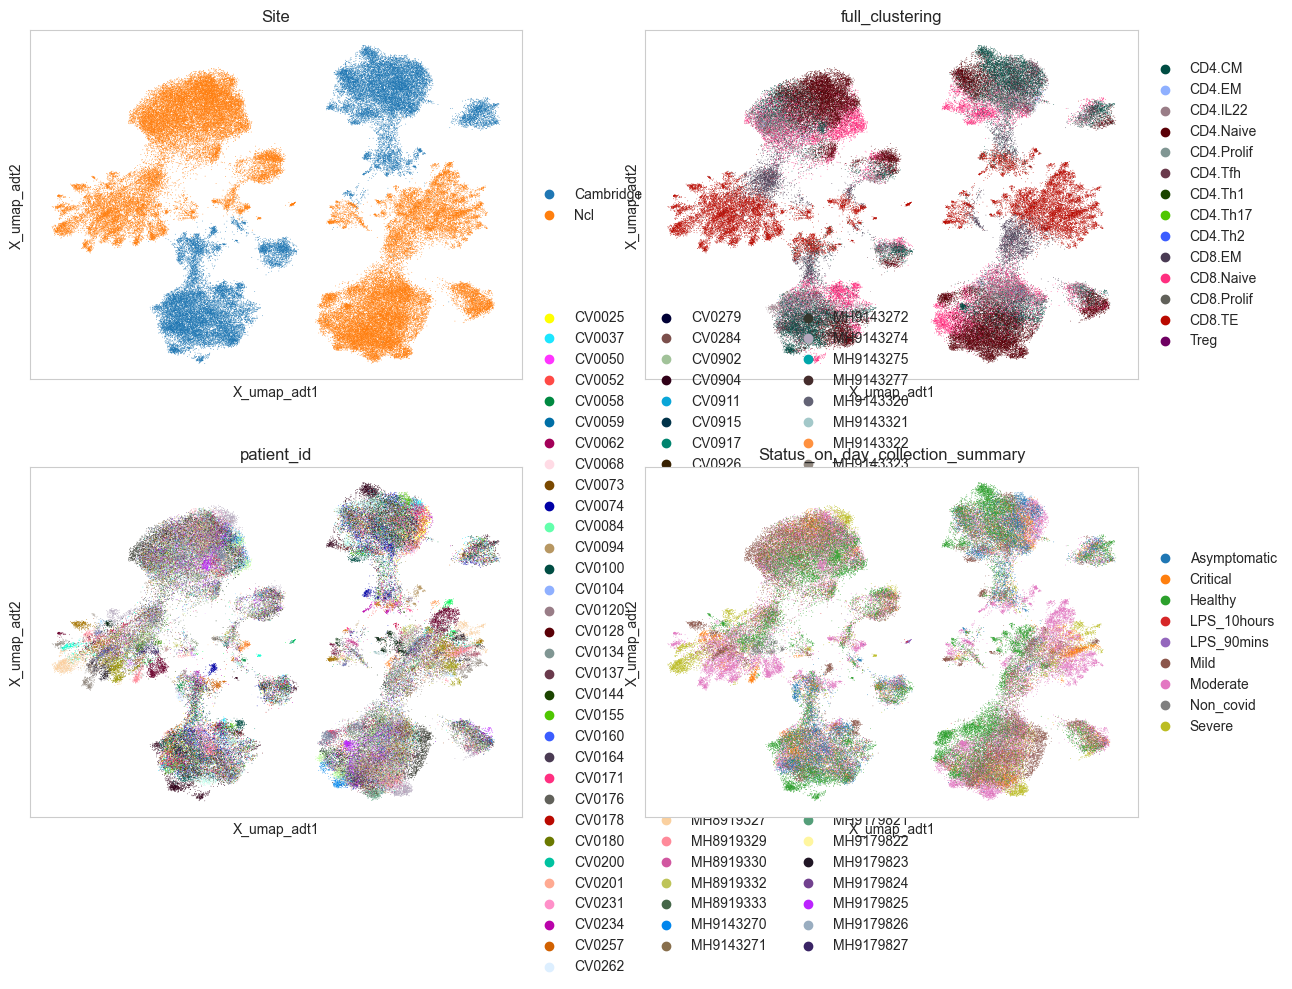

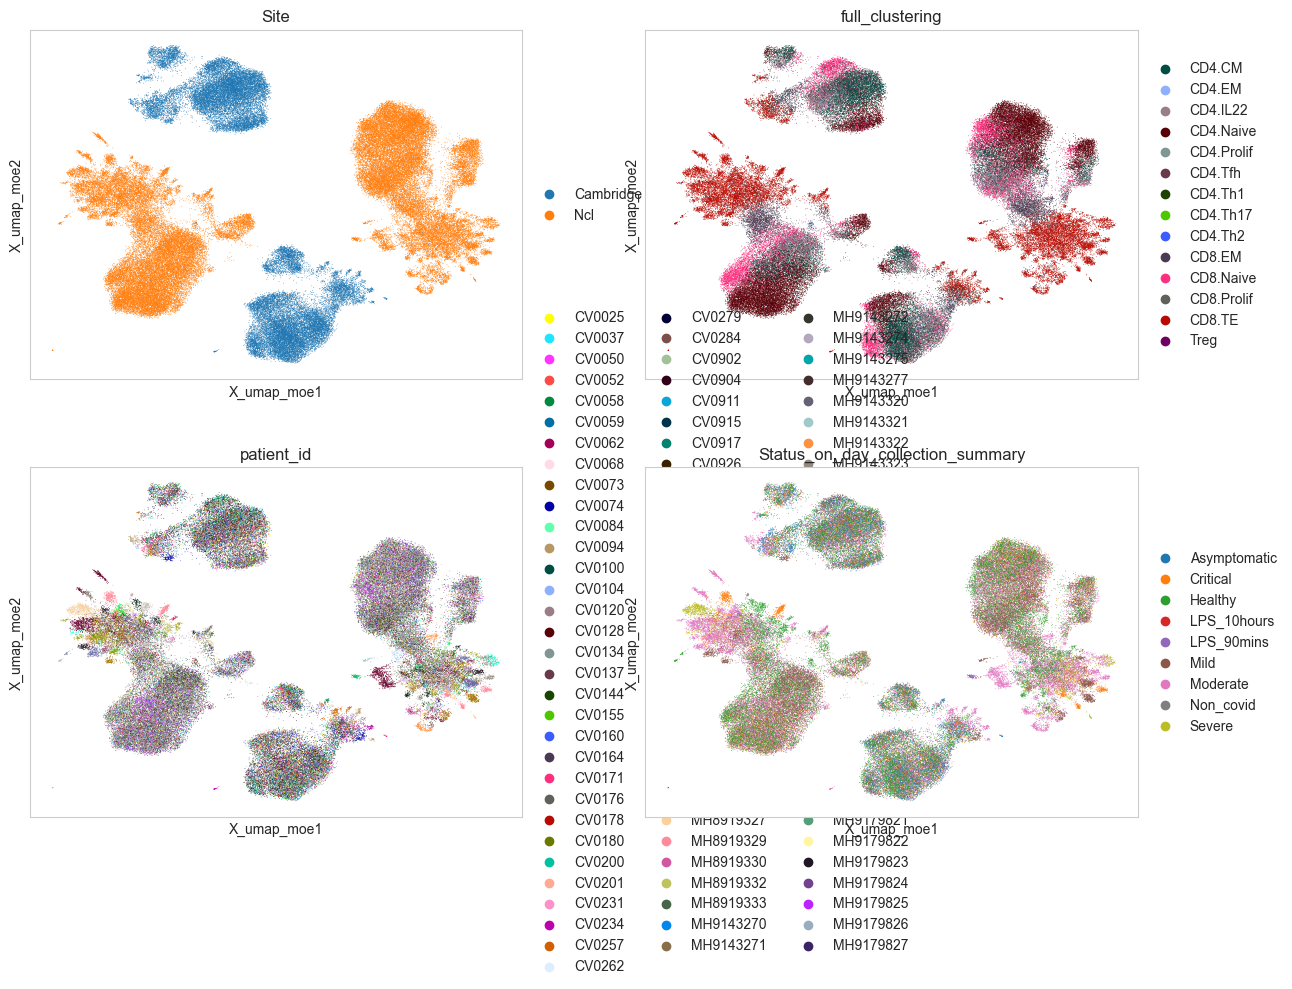

In [10]:
sc.pl.embedding(data, basis='X_umap_adt', color=['Site', 'full_clustering', 'patient_id',
                                                 'Status_on_day_collection_summary'], ncols=2)
sc.pl.embedding(data, basis='X_umap_moe', color=['Site', 'full_clustering', 'patient_id',
                                                 'Status_on_day_collection_summary'], ncols=2)

## Evalution

In [11]:
from sklearn.metrics import normalized_mutual_info_score

#Status_on_day_collection
def evaluate_leiden(latent_full, col='Status_on_day_collection'):
    if 'Status' in col:
        latent = latent_full[latent_full.obs['full_clustering']=='CD8.TE']
    else:
        latent = latent_full   
    latent = latent[latent.obs[col].notna()]
    nmi = normalized_mutual_info_score(latent.obs[col], 
                                                  latent.obs['leiden'], average_method='arithmetic')
    return nmi

In [12]:
def evaluate_leiden_std(latent_full, col='Days_from_onset'):
    latent_tmp = latent_full[~latent_full.obs[col].isin(['Healthy', 'Non_covid', 'LPS', 'nan'])]
    latent_tmp.obs[col] = latent_tmp.obs[col].astype(str).astype(int)
    score = latent_tmp.obs.groupby('leiden')[col].std()
    score = score.mean()
    return score

In [13]:
models_2_latent = {
    'mvTCR-ADT': latent_adt,
    'mvTCR': latent_moe,
}

In [14]:
models = []
metrics = []
values = []

for name, latent in models_2_latent.items():
    print(name)
    sc.pp.neighbors(latent)
    sc.tl.leiden(latent, resolution=1.)
    for col in ['Status_on_day_collection', 'full_clustering', 'clonotype']:
        print(col)
        val = evaluate_leiden(latent, col)
        models.append(name)
        metrics.append(f'NMI - {col}')
        values.append(val)

res = pd.DataFrame({
    'Model': models,
    'Metric': metrics,
    'Value': values
})
res.to_csv(f'../results/performance_haniffa_adt.csv')
res

mvTCR-ADT
Status_on_day_collection
full_clustering
clonotype
mvTCR
Status_on_day_collection
full_clustering
clonotype


,Model,Metric,Value
0,mvTCR-ADT,NMI - Status_on_day_collection,0.215798
1,mvTCR-ADT,NMI - full_clustering,0.291092
2,mvTCR-ADT,NMI - clonotype,0.419018
3,mvTCR,NMI - Status_on_day_collection,0.166058
4,mvTCR,NMI - full_clustering,0.300500
5,mvTCR,NMI - clonotype,0.403337


In [15]:
path_out = '../results/supplement/S1_benchmarking.xlsx'
with pd.ExcelWriter(path_out, mode='a') as writer: 
    res.to_excel(writer, sheet_name='SARS-CoV-2_ADT')

## Similar TCRs

In [16]:
latent_moe_tcr = moe_model.get_all_latent(data, metadata=[], return_mean=True)
latent_moe_tcr = [batch[1].detach().cpu().numpy() for batch in latent_moe_tcr]
latent_moe_tcr = np.vstack(latent_moe_tcr)
latent_moe_tcr = sc.AnnData(X=latent_moe_tcr)
latent_moe_tcr.obs = latent_moe.obs

In [17]:
data.obs['receptor_type'] = 'TCR'
ir.pp.ir_dist(data, metric='hamming', sequence='aa', cutoff=1)
ir.tl.define_clonotype_clusters(data, metric='hamming', sequence='aa', receptor_arms='VDJ', dual_ir='primary_only')

100%|███████████████████████████████████████████████████████████████████████████| 78768/78768 [02:48<00:00, 466.71it/s]


In [18]:
col = 'IR_VDJ_1_junction_aa'
df_embedding = pd.DataFrame(data=latent_moe_tcr.X, index=latent_moe_tcr.obs.index)
df_embedding[col] = data.obs[col]
df_embedding = df_embedding.groupby(col).mean()
df_embedding

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
IR_VDJ_1_junction_aa,,,,,,,,,,,,,,,,,,,,,
CAAAEQAEETQYF,2.616653,-0.881979,-0.209564,-2.872541,-0.890855,-0.142248,2.578392,-2.874064,2.642512,-5.248734,...,-3.693862,-6.935552,-0.155367,3.352340,0.424092,5.857292,1.286648,3.048020,-3.301864,2.799801
CAAAGQTQYF,-0.844666,1.718020,-2.125745,-1.942575,2.974763,0.576430,0.049011,-3.669397,-2.856180,-4.769432,...,-4.518320,-7.342558,-3.336407,4.617807,3.233281,0.631522,0.896420,2.364280,-0.183217,3.622241
CAAAGTGDSPLHF,-2.318660,0.392243,-0.282831,1.748891,-0.854662,1.790506,-2.353597,3.152408,-5.386209,2.945671,...,1.954245,6.378632,-0.210311,-5.145015,-1.372083,-4.472964,2.207240,-0.277774,2.419900,0.906264
CAAAIRGNYGYTF,-0.835402,1.459485,-0.714919,-3.689755,0.734433,-2.210000,2.077049,-2.595954,-2.827840,-5.779593,...,-2.767539,-6.532069,-1.216129,6.328204,1.378843,1.432110,1.420525,2.985223,0.815200,1.425252
CAAALGGGTDTQYF,-0.485551,-0.085042,-0.590097,0.471342,-2.302865,4.035550,-6.894317,0.828904,-4.739555,0.768061,...,0.754715,3.405443,0.187873,-5.132460,-0.266374,-1.979850,2.144480,-0.570761,2.007528,0.845167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CVTGTGLNQPQHF,-3.435153,1.048998,0.818218,1.836128,-1.456717,4.035554,-1.570666,1.507572,-4.581137,2.459139,...,3.788679,3.662300,-0.732715,-5.852190,0.555906,-4.086529,2.393042,-0.423004,3.114477,2.568681
CVTGTGRNENTEAFF,-0.052629,0.624315,-0.214409,-2.821555,2.862237,-3.686813,6.504623,-1.756000,0.444692,-3.388203,...,-2.779451,-4.291908,3.124588,5.002371,-0.191766,1.563521,2.903923,5.680480,1.206551,4.472085
CVTGTSGGNEQFF,0.604494,-0.263562,1.275785,0.143431,2.935712,-0.842008,4.462276,-3.597062,0.013371,-4.468903,...,-1.788970,-5.640608,1.220271,3.734722,-0.075669,1.806215,-0.061304,7.072586,2.319192,4.394401


In [19]:
cdr3b_2_cc = data.obs[[col, 'cc_aa_hamming']].drop_duplicates()
cdr3b_2_cc = dict(zip(cdr3b_2_cc[col], cdr3b_2_cc['cc_aa_hamming']))
df_embedding['hamming_cluster'] = df_embedding.index.map(cdr3b_2_cc)

In [20]:
def get_dist(embs):
    pairwise_distances = squareform(pdist(embs, 'euclidean'))
    upper_half_indices = np.triu_indices_from(pairwise_distances, k=1)
    avg_dist = pairwise_distances[upper_half_indices].mean()
    return avg_dist

In [21]:
from scipy.spatial.distance import pdist, squareform
expaned_clusters = df_embedding['hamming_cluster'].value_counts()
expaned_clusters = expaned_clusters[expaned_clusters>1].index.tolist()

cols = list(range(25))
avg_dists = []
for cluster in tqdm(expaned_clusters):
    embs = df_embedding[df_embedding['hamming_cluster']==cluster][cols].values
    avg_dist = get_dist(embs)
    avg_dists.append(avg_dist)
    
sum(avg_dists)/len(avg_dists)

100%|██████████████████████████████████████████████████████████████████████████████| 2992/2992 [04:31<00:00, 11.02it/s]


11.601760963919405

In [22]:
cluster_sizes = df_embedding['hamming_cluster'].value_counts()
cluster_sizes = cluster_sizes[cluster_sizes>1].values.tolist()

In [23]:
avg_rdm_dists = []
for size in tqdm(cluster_sizes):
    embs = df_embedding[cols].values
    random_idcs = np.random.choice(embs.shape[0], size=size, replace=False)
    embs = embs[random_idcs]
    avg_dist = get_dist(embs)
    avg_rdm_dists.append(avg_dist)
sum(avg_rdm_dists)/len(avg_rdm_dists)

100%|█████████████████████████████████████████████████████████████████████████████| 2992/2992 [00:17<00:00, 170.38it/s]


21.557964643943492

Ttest_indResult(statistic=-59.661559567987034, pvalue=0.0)


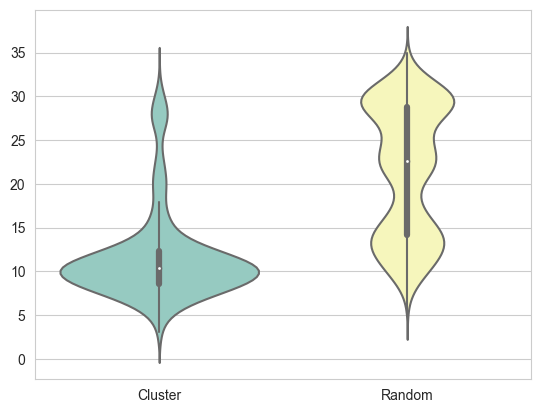

In [24]:
from scipy.stats import ttest_ind
df_dists = pd.DataFrame({'Cluster': avg_dists, 'Random': avg_rdm_dists})
sb.violinplot(data=df_dists, palette="Set3")
print(ttest_ind(avg_dists, avg_rdm_dists))

In [25]:
df_dists.to_csv(f'../results/performance_hamming_clusters.csv')